# Using multi-agent RL with Ray RLlib

Here, we are going to implement a multi-agent RL based on Proximal Policy Optimization (PPO) algorithm using Ray RLlib. We are going to utilize the custom environment RobotsMeeting created in [lesson 3 nb 1](./1-exploring_multi_agent_environment.ipynb).

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium.spaces as spaces
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.tune.registry import register_env
import numpy as np
from ray import air, tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from typing import Dict
from ray.rllib.policy.policy import PolicySpec

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

The cell below implements the environment for the cooperative navigation problem explained in the previous notebook [lesson 3 nb 1](./1-exploring_multi_agent_environment.ipynb).

In [2]:
class RobotsMeeting(
    MultiAgentEnv
):  # We have to inherit from MultiAgentEnv from Ray RLlib similarly to Gymnasium API
    def __init__(
        self,
        scenario_size: int = 10,
        render: bool = False,
    ):
        self.scenario_size = scenario_size  # scenario_size x scenario_size grid
        self.agents = {"robot_" + str(r) for r in range(2)}
        self._agent_ids = set(self.agents)
        self._obs_space_in_preferred_format = True
        self._action_space_in_preferred_format = True
        self.scenario = np.zeros((self.scenario_size, self.scenario_size))
        self.action_space = spaces.Dict(
            {
                "robot_1": spaces.Discrete(4),  # 0: up, 1: down, 2: left, 3: right
                "robot_2": spaces.Discrete(4),
            }
        )
        self.step_number = 0
        self.observation_space = spaces.Dict(
            {
                "robot_1": spaces.MultiDiscrete(
                    nvec=[
                        self.scenario_size,
                        self.scenario_size,
                        self.scenario_size,
                        self.scenario_size,
                    ]
                ),  # Position of robot 1 and robot 2
                "robot_2": spaces.MultiDiscrete(
                    nvec=[
                        self.scenario_size,
                        self.scenario_size,
                        self.scenario_size,
                        self.scenario_size,
                    ]
                ),
            }
        )
        self.robots = {
            "robot_1": {
                "number": 1,
                "pos": [0, 0],
            },
            "robot_2": {
                "number": 2,
                "pos": [self.scenario_size - 1, self.scenario_size - 1],
            },
        }
        self.scenario[0, 0] = self.robots["robot_1"]["number"]
        self.scenario[self.scenario_size - 1, self.scenario_size - 1] = self.robots[
            "robot_2"
        ]["number"]
        if render:
            plt.figure()
            plt.show()
            self.render()

    def reset(self, seed, options):
        # Reseting scenario and returning robots to initial positions
        self.scenario = np.zeros((self.scenario_size, self.scenario_size))
        self.scenario[0, 0] = self.robots["robot_1"]["number"]
        self.robots["robot_1"]["pos"] = [0, 0]
        self.scenario[self.scenario_size - 1, self.scenario_size - 1] = self.robots[
            "robot_2"
        ]["number"]
        self.robots["robot_2"]["pos"] = [self.scenario_size - 1, self.scenario_size - 1]
        self.step_number = 0
        obs = {
            "robot_1": np.append(
                self.robots["robot_1"]["pos"], self.robots["robot_2"]["pos"]
            ),
            "robot_2": np.append(
                self.robots["robot_1"]["pos"], self.robots["robot_2"]["pos"]
            ),
        }
        info = {}

        return (obs, info)

    def step(self, action_dict):
        for agent, action in action_dict.items():
            if action == 0:  # Up
                if self.robots[agent]["pos"][0] == 0:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0] - 1, self.robots[agent]["pos"][1]
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][0] -= 1
            elif action == 1:  # Down
                if self.robots[agent]["pos"][0] == self.scenario_size - 1:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0] + 1, self.robots[agent]["pos"][1]
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][0] += 1
            elif action == 2:  # Left
                if self.robots[agent]["pos"][1] == 0:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1] - 1
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][1] -= 1
            elif action == 3:  # Right
                if self.robots[agent]["pos"][1] == self.scenario_size - 1:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1] + 1
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][1] += 1
            else:
                raise ValueError("Invalid action")
        self.step_number += 1
        distance = np.abs(  # Calculate the distance between two robots
            self.robots["robot_1"]["pos"][0] - self.robots["robot_2"]["pos"][0]
        ) + np.abs(self.robots["robot_1"]["pos"][1] - self.robots["robot_2"]["pos"][1])
        obs = {
            "robot_1": np.append(
                self.robots["robot_1"]["pos"], self.robots["robot_2"]["pos"]
            ),
            "robot_2": np.append(
                self.robots["robot_1"]["pos"], self.robots["robot_2"]["pos"]
            ),
        }
        reward_value = -distance  # Reward is -distance
        done = (
            True if reward_value == 0 else False
        )  # Terminate the episode if the robots meet
        reward = {"robot_1": reward_value, "robot_2": reward_value}
        terminated = {"player_1": done, "player_2": done}
        truncated = {"player_1": done, "player_2": done}
        terminated["__all__"], truncated["__all__"] = done, done
        info = {}

        return (obs, reward, terminated, truncated, info)

    def render(self):
        clear_output(wait=True)
        plt.imshow(self.scenario)
        plt.show()

    def close(self):
        plt.close()

Registering our custom environment in the Ray RLlib:

In [3]:
def env_creator(env_config):
    env = RobotsMeeting(scenario_size=10, render=False)
    return env


register_env("robots_meeting", lambda config: env_creator(config))

## Creating the multi-agent RL using PPO

The code below is the responsible to create two different policies (one for each robot).

In [5]:
def generate_policies() -> Dict[str, PolicySpec]:
    policies = {
        "robot_1": PolicySpec(),
        "robot_2": PolicySpec(),
    }

    return policies

The function below associate each robot for a specific policy.

In [4]:
def policy_mapping_fn(agent_id, episode=None, worker=None, **kwargs):
    agent_idx = int(agent_id.partition("_")[2])

    return "robot_1" if agent_idx == 1 else "robot_2"

Then, we can create the MARL agent using the `multi_agent` callback from `PPOConfig` where we pass the functions to create and associate policies.

In [6]:
algo_config = (
    PPOConfig()
    .environment(
        env="robots_meeting",
    )
    .multi_agent(
        policies=generate_policies(),
        policy_mapping_fn=policy_mapping_fn,
        count_steps_by="env_steps",
    )
    .training(
        train_batch_size=200,
        sgd_minibatch_size=50,
    )
    .framework("torch")
)

The training process implemented in the cell below is exactly the same used in a single-agent training.

In [7]:
stop = {
    "num_env_steps_sampled": 10000,  # 10000 environment steps
}
checkpoint_frequency = 0
store_results_path = str(Path("./ray_results/").resolve()) + "/nb_2/"
agent_name = "ray_ppo"

tuner = tune.Tuner(
    "PPO",
    param_space=algo_config.to_dict(),
    run_config=air.RunConfig(
        storage_path=store_results_path,
        name=agent_name,
        stop=stop,
        verbose=2,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_frequency=checkpoint_frequency,
            checkpoint_at_end=True,
        ),
    ),
)
results = tuner.fit()
print(results)

2024-12-07 15:21:37,480	INFO worker.py:1783 -- Started a local Ray instance.
2024-12-07 15:21:37,998	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-12-07 15:21:38,000	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, act

(PPO pid=695821) Install gputil for GPU system monitoring.
(PPO pid=695821) 2024-12-07 15:21:46,478	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!


2024-12-07 15:23:10,687	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lasse/ray_minicourse/lesson_3/ray_results/nb_2/ray_ppo' in 0.0128s.
(PPO pid=695821) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/lasse/ray_minicourse/lesson_3/ray_results/nb_2/ray_ppo/PPO_robots_meeting_f3d9b_00000_0_2024-12-07_15-21-38/checkpoint_000000)
2024-12-07 15:23:11,299	INFO tune.py:1041 -- Total run time: 93.30 seconds (92.64 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'robot_2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.5936879495779672, 'cur_kl_coeff': 0.00021972656250000006, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 8.334545095761618, 'policy_loss': -0.04041279072698671, 'vf_loss': 8.37495540380478, 'vf_explained_var': -0.0040723904967308044, 'kl': 0.01133483401901021, 'entropy': 0.6955343385537466, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 50.0, 'num_grad_updates_lifetime': 5940.5, 'diff_num_grad_updates_vs_sampler_policy': 59.5}, 'robot_1': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 2.3928737143675485, 'cur_kl_coeff': 5.4931640625000015e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 8.24058399995168, 'policy_loss': -0.03297920865091631, 'vf_loss': 8.273562939961751, 'vf_explained_var': 0.021410337587197622, 'kl': 0.005922839306840611, 'entropy': 0.46499678492

In [8]:
analysis = tune.ExperimentAnalysis(f"{store_results_path}/{agent_name}/")
assert analysis.trials is not None, "Analysis trial is None"
checkpoint = analysis.get_best_checkpoint(
    trial=analysis.trials[0], metric="env_runners/episode_reward_mean", mode="max"
)
tuner_agent = Algorithm.from_checkpoint(checkpoint)

2024-12-07 15:23:11,361	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:557: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tun

So, let's test our trained agents in an episode of the environment. There is a small difference to compose the agent action since now we utilize two different RL agents.

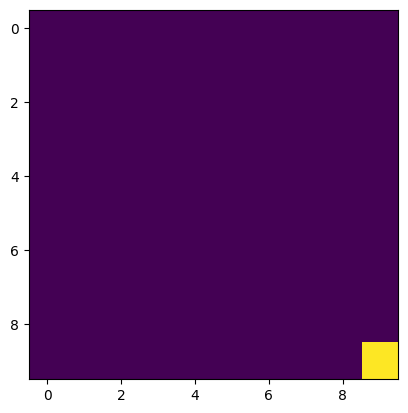

20


In [ ]:
env = env_creator({})
obs, _ = env.reset(seed=0, options={})  # Initial observation
terminated = {"__all__": False}
number_steps = 0
while not terminated["__all__"]:
    action = {}
    assert isinstance(obs, dict), "Observations must be a dictionary."
    for (
        agent_id,
        agent_obs,
    ) in (
        obs.items()
    ):  # We need to iterate for each agent to compose the action (dictionary)
        policy_id = policy_mapping_fn(agent_id)
        action[agent_id] = tuner_agent.compute_single_action(
            agent_obs,
            policy_id=policy_id,
            explore=True,
        )
    obs, reward, terminated, truncated, info = env.step(
        action
    )  # Applying the action in the environment
    number_steps += 1
    env.render()  # Rendering the environment
print(number_steps)